In [1]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 58.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 93.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 85.2 MB/s eta 0:00:00


In [2]:
import numpy as np
import tensorflow as tf
import keras
import tensorflow_probability as tfp
from tensorflow.keras.layers import Input, Dense, Reshape, UpSampling2D, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from transformers import LongformerModel

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Set the input and output shapes
INPUT_SHAPE = (128, 128, 4)  # Input shape of the model
OUTPUT_SHAPE = (128, 128, 1)  # Output shape of the model

In [5]:
min_max = '/content/drive/MyDrive/example1/min_max_scale_new.npy'
min, max = np.load(min_max, encoding='bytes')
print(min, max)

-236.2857142857143 295.5714285714286


In [6]:
# Load and preprocess the data
def load_data(file_path):
    data = np.load(file_path)
    return data

def preprocess_data(file_list):
    # data = []
    # labels = []
    loaded_data = []
    for file_name in file_list:
        file_path = '/content/drive/MyDrive/example1/' + file_name
        loaded_data.append(load_data(file_path))
    return np.array(loaded_data)


def generate_data(data,min_train,max_train):
    # data shape=(n_samples, row, col, timesteps)
    n_samples=data.shape[0]
    time_step=data.shape[3]
    row=128
    col=128

    # replace the pixel of "no echo (-127)" as 0
    data[data<=-127]=0

    # for training dataset (t-30,t-20,t-10,t,1+10)
    n_frames=4
    movie_in=np.zeros((n_samples,row,col,n_frames))
    movie_out=np.zeros((n_samples,row,col,1))
    for i in range(n_samples):
        for j in range(n_frames):
            m_in=(255.*((data[i,::,::,j]+10.)/70.))+0.5
            movie_in[i,::,::,j]=m_in
        m_out=(255.*((data[i,::,::,-1]+10.)/70.))+0.5
        movie_out[i,::,::,0]=m_out

    # Min-max scaling
    movie_in=(movie_in-min_train)/(max_train-min_train)
    movie_out=(movie_out-min_train)/(max_train-min_train)

    return movie_in, movie_out


In [7]:
# Load the training and testing data
train_file_list = np.loadtxt('/content/drive/MyDrive/example1/radar_events_train.txt', dtype=str)
test_file_list = np.loadtxt('/content/drive/MyDrive/example1/radar_events_test.txt', dtype=str)

data_train = preprocess_data(train_file_list)
data_test = preprocess_data(test_file_list)


x_train, y_train = generate_data(data_train, min, max)
x_test, y_test = generate_data(data_test, min, max)

In [8]:
x_test_temp = np.moveaxis(x_test,3,1)

In [9]:
y_test_temp = y_test.reshape(y_test.shape[0],1,128,128,1)
x_test_temp = x_test.reshape(x_test.shape[0],4,128,128,1)

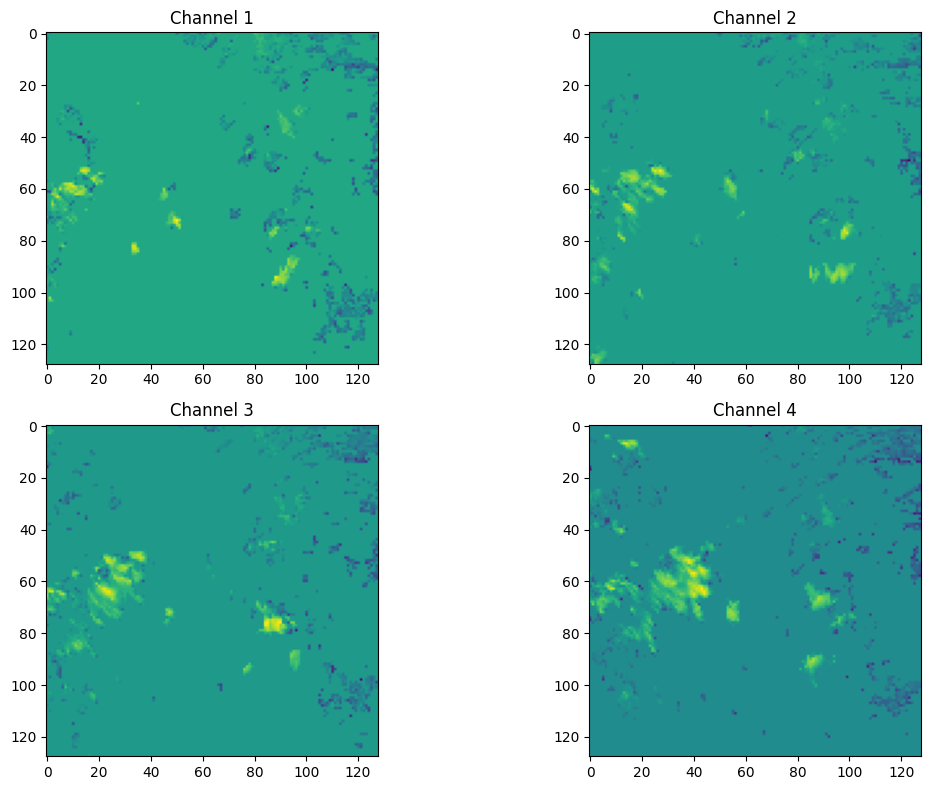

In [11]:
import matplotlib.pyplot as plt

# Split the input data into separate channels
channel1 = x_train[0, :, :, 0]
channel2 = x_train[0, :, :, 1]
channel3 = x_train[0, :, :, 2]
channel4 = x_train[0, :, :, 3]

# Plot the input channels
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.imshow(channel1)
plt.title('Channel 1')
plt.subplot(2, 2, 2)
plt.imshow(channel2)
plt.title('Channel 2')
plt.subplot(2, 2, 3)
plt.imshow(channel3)
plt.title('Channel 3')
plt.subplot(2, 2, 4)
plt.imshow(channel4)
plt.title('Channel 4')
plt.tight_layout()
plt.show()

In [12]:
# Vision Transformer

image_size = 128
patch_size = 16
num_patches = (image_size//patch_size) **2

# hyper parameters for the ViT module
projection_dim = 64 # size of hidden dimension feature vectors in our model
                     # project patches into these 64-dimensional feature vectors that are concatenated together
                     # as input to encoder layer

num_heads = 8  #no. of heads in multi head attention layer, four separate transformations

# We are going to overriding the mlp layer to add a skip connection like resnet.
# In transformer, we have skip connection from the output of self attention and then it goes to feed
# forward layer that's going to compress the dimensionality and then you skip ahead with the previous output
# from the previous dense layer

#parametrization of the skip connection
transformer_units = [projection_dim*2,projection_dim]
#two stacked transformer layers
transformer_layers = 8
mlp_head_units = [4096,2048]  # Size of the dense layers of the final classifier
#custom MLP to add skip connection
def mlp(x, hidden_units, dropout_rate):
  for units in hidden_units:
    x = layers.Dense(units, activation=tf.nn.gelu)(x)
    x = layers.Dropout(dropout_rate)(x)
  return x                                                                                                                                                                                                    #overriding keras layer object to implement the patches layer
class Patches(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def get_config(self):
      config = super().get_config()
      config.update({
          'patch_size': self.patch_size
      })
      return config


    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches                                                                                                                                                                               # The PatchEncoder layer will linearly transform a patch by projecting it into a
# vector of size projection_dim. In addition, it adds a learnable position
# embedding to the projected vector.
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, **kwargs):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def get_config(self):
      config = super().get_config()
      config.update({
          'num_patches': self.num_patches,
          'projection': self.projection,
          'position_embedding': self.position_embedding
      })
      return config

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded
def create_vit(inputs):
    # Create patches.
    patches = Patches(patch_size)(inputs)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches=num_patches, projection_dim=projection_dim)(patches)
    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    return encoded_patches

def create_model(input_shape):
    inputs = Input(shape=input_shape)

    # Split the input tensor into individual timestamps
    timestamps = tf.split(inputs, num_or_size_splits=4, axis=-1)

    llayers = []
    for timestamp in timestamps:
        timestamp = tf.reshape(timestamp, [-1, 128, 128, 1])
        llayers.append(create_vit(timestamp))

    vit = tf.stack(llayers, axis=-1)
    vit = tf.reshape(vit, (-1, 64, 64, 4))  # Reshape the ViT output to (None, 64, 64, 4)

    # Reshape the data to match LSTM input requirements
    reshaped_vit = Reshape(target_shape=(64*64, 4))(vit)

    lstm = layers.LSTM(128, input_shape=(64*64, 4), return_sequences=True)(reshaped_vit)
    # Upsampling decoder
    decoded = Reshape(target_shape=(64, 64, 128))(lstm)
    decoded = UpSampling2D(size=(2, 2))(decoded)
    output = Conv2D(1, (3, 3), activation='relu', padding='same')(decoded)

    model = Model(inputs=inputs, outputs=output)
    return model

In [13]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import ConvLSTM2D
from keras.layers.convolutional import Conv3D
from keras.layers import LayerNormalization, Reshape, Lambda
import keras.backend as K

model = Sequential()
model.add(ConvLSTM2D(filters=64,
                     kernel_size=(3, 3),
                     padding='same',
                     kernel_initializer='HeNormal',
                     input_shape=(None, 128, 128, 1),
                     return_sequences=True))
model.add(LayerNormalization())
model.add(ConvLSTM2D(filters=64,
                     kernel_size=(3, 3),
                     padding='same',
                     kernel_initializer='HeNormal',
                     return_sequences=True))
model.add(LayerNormalization())
model.add(ConvLSTM2D(filters=64,
                     kernel_size=(3, 3),
                     padding='same',
                     kernel_initializer='HeNormal',
                     return_sequences=True))
model.add(LayerNormalization())
model.add(Conv3D(filters=1,
                 kernel_size=(3, 3, 3),
                 padding='same',
                 activation='linear',
                 data_format='channels_last'))

# Define a Lambda layer for element-wise multiplication along the second axis
multiply_layer = Lambda(lambda x: K.prod(x, axis=1, keepdims=True))
model.add(multiply_layer)

model.compile(loss='mse', optimizer='adam')
model.build((None, 4, 128, 128, 1))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, None, 128, 128, 6  150016    
                             4)                                  
                                                                 
 layer_normalization (LayerN  (None, None, 128, 128, 6  128      
 ormalization)               4)                                  
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, None, 128, 128, 6  295168    
                             4)                                  
                                                                 
 layer_normalization_1 (Laye  (None, None, 128, 128, 6  128      
 rNormalization)             4)                                  
                                                                 
 conv_lstm2d_2 (ConvLSTM2D)  (None, None, 128, 128, 6  2

In [14]:
vision_transformer= tf.keras.models.load_model('/content/drive/MyDrive/Models/transformer_model.h5', custom_objects={"Patches": Patches, "PatchEncoder": PatchEncoder})

In [15]:
u_net=tf.keras.models.load_model('/content/drive/MyDrive/Models/u_net_model.h5')

In [16]:
cGan=tf.keras.models.load_model('/content/drive/MyDrive/Models/Pre-trained model_Soyang-gang.h5')

In [17]:
cGan.compile(loss='binary_crossentropy')

In [18]:
ConvLSTM=tf.keras.models.load_model('/content/drive/MyDrive/Models/ConvLSTM.h5')

In [19]:
transformer_loss=vision_transformer.evaluate(x_test,y_test,verbose=0)
print(transformer_loss)

0.648483157157898


In [20]:
u_net_loss=u_net.evaluate(x_test,y_test,verbose=0)
print(u_net_loss)

9.092763900756836


In [21]:
cGan_loss=cGan.evaluate(x_test,y_test,verbose=0)
print(cGan_loss)

0.6488077640533447


In [22]:
ConvLSTM_loss=ConvLSTM.evaluate(x_test_temp, y_test_temp, verbose=0)
print(ConvLSTM_loss)

0.020996613427996635


In [23]:
predictions_transformer = vision_transformer.predict(x_test)

39/39 [==============================] - 8s 79ms/step


In [24]:
predictions_u_net= u_net.predict(x_test)

39/39 [==============================] - 2s 45ms/step


In [25]:
predictions_cGan= cGan.predict(x_test)

39/39 [==============================] - 2s 44ms/step


In [26]:
predictions_ConvLSTM=ConvLSTM.predict(x_test_temp)

39/39 [==============================] - 9s 231ms/step


In [27]:
predictions_ConvLSTM.shape

(1247, 1, 128, 128, 1)

In [39]:
predictions_ConvLSTM=predictions_ConvLSTM.reshape(1247,128,128,1)

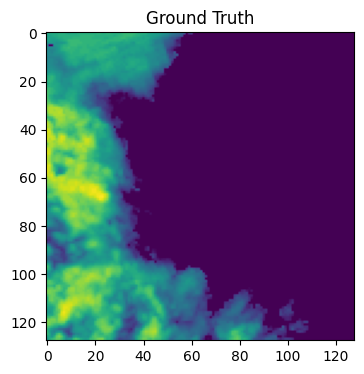

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.title('Ground Truth')
plt.imshow(y_test[4])
plt.show()

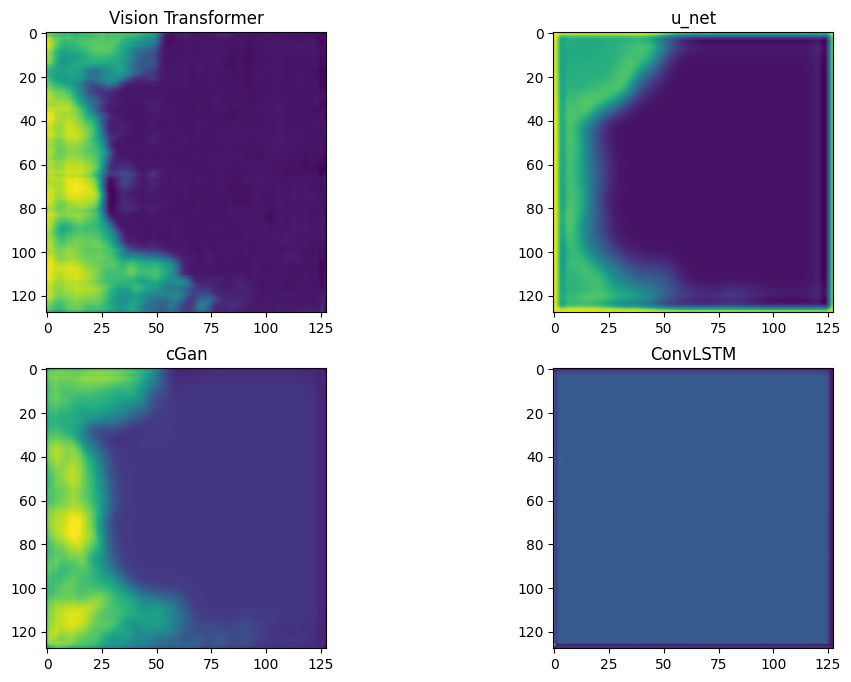

In [40]:
# Plot the first input and labeled data
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.imshow(predictions_transformer[4])
plt.title('Vision Transformer')
plt.subplot(2, 2, 2)
plt.imshow(predictions_u_net[4])
plt.title('u_net')
plt.subplot(2, 2, 3)
plt.imshow(predictions_cGan[4])
plt.title('cGan')
plt.subplot(2, 2, 4)
plt.imshow(predictions_ConvLSTM[4])
plt.title('ConvLSTM')
plt.show()

In [31]:
def convert_zr(reflectivity, a, b):
    reflectivity = np.where(reflectivity <= 0, 1e-5, reflectivity)
    precipitation = a * (reflectivity ** b)
    return precipitation

In [41]:
a=200
b=1.6
y_true_prpt=convert_zr(y_test,a,b)
y_predicted_transformer_prpt=convert_zr(predictions_transformer,a,b)
y_predicted_u_net_prpt=convert_zr(predictions_u_net,a,b)
y_predicted_cGan_prpt=convert_zr(predictions_cGan,a,b)
y_predicted_ConvLSTM_prpt=convert_zr(predictions_ConvLSTM,a,b)

In [34]:
# Define evaluation metrics
def pearson_correlation(y_true, y_pred):
    return tfp.stats.correlation(y_true, y_pred)

In [35]:
def root_mean_square_error(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

In [42]:
print('root_mean_square_error\n')
print('vision transformer',root_mean_square_error(y_true_prpt,y_predicted_transformer_prpt))
print('u_net',root_mean_square_error(y_true_prpt,y_predicted_u_net_prpt))
print('cGan',root_mean_square_error(y_true_prpt,y_predicted_cGan_prpt))
print('ConvLSTM',root_mean_square_error(y_true_prpt,y_predicted_ConvLSTM_prpt))

root_mean_square_error

vision transformer tf.Tensor(9.177413489901944, shape=(), dtype=float64)
u_net tf.Tensor(96.13559240043021, shape=(), dtype=float64)
cGan tf.Tensor(9.758450524308566, shape=(), dtype=float64)
ConvLSTM tf.Tensor(29.15939533731993, shape=(), dtype=float64)


In [44]:
def nash_sutcliffe_efficiency(y_true, y_pred):
    numerator = tf.reduce_sum(tf.square(y_true - y_pred))
    denominator = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - (numerator / denominator)

In [45]:
print('nash_sutcliffe_efficiency\n')
print('vision transformer',nash_sutcliffe_efficiency(y_true_prpt,y_predicted_transformer_prpt))
print('u_net',nash_sutcliffe_efficiency(y_true_prpt,y_predicted_u_net_prpt))
print('cGan',nash_sutcliffe_efficiency(y_true_prpt,y_predicted_cGan_prpt))
print('ConvLSTM',nash_sutcliffe_efficiency(y_true_prpt,y_predicted_ConvLSTM_prpt))

nash_sutcliffe_efficiency

vision transformer tf.Tensor(0.8264384782946372, shape=(), dtype=float64)
u_net tf.Tensor(-18.045012590643406, shape=(), dtype=float64)
cGan tf.Tensor(0.8037658540188568, shape=(), dtype=float64)
ConvLSTM tf.Tensor(-0.7521443335123021, shape=(), dtype=float64)


In [46]:
def critical_success_index(y_true, y_pred):
    threshold = 0.5  # Adjust the threshold as needed
    y_true_bin = tf.where(y_true > threshold, 1, 0)
    y_pred_bin = tf.where(y_pred > threshold, 1, 0)
    true_positive = tf.reduce_sum(y_true_bin * y_pred_bin)
    false_positive = tf.reduce_sum((1 - y_true_bin) * y_pred_bin)
    false_negative = tf.reduce_sum(y_true_bin * (1 - y_pred_bin))

    # Calculate the critical success index
    critical_success_index = true_positive / (true_positive + false_positive + false_negative)

    return critical_success_index

In [47]:
print('critical_success_index\n')
print('vision transformer',critical_success_index(y_true_prpt,y_predicted_transformer_prpt))
print('u_net',critical_success_index(y_true_prpt,y_predicted_u_net_prpt))
print('cGan',critical_success_index(y_true_prpt,y_predicted_cGan_prpt))
print('ConvLSTM',critical_success_index(y_true_prpt,y_predicted_ConvLSTM_prpt))

critical_success_index

vision transformer tf.Tensor(1.0, shape=(), dtype=float64)
u_net tf.Tensor(0.05205226919607057, shape=(), dtype=float64)
cGan tf.Tensor(1.0, shape=(), dtype=float64)
ConvLSTM tf.Tensor(0.9841394737996191, shape=(), dtype=float64)
